In [2]:
import os
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,Rescaling
import numpy as np
from keras.layers import GaussianNoise
import tensorflow_addons as tfa

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)
physical_devices = tf.config.list_physical_devices("GPU")
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Mounted at /content/gdrive


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:

import numpy as np
from skimage.util import random_noise 

datagen = ImageDataGenerator( rotation_range=20, zoom_range=0.2,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1,
 fill_mode="nearest",rescale=1.0/255.0 ,dtype="numpy.float32",preprocessing_function=preprocess_input)
data = ImageDataGenerator(rescale=1.0/255.0,dtype="numpy.float32",preprocessing_function=preprocess_input)

ds_train = datagen.flow_from_directory(
    '/content/gdrive/My Drive/training',
      # categorical, binary
    classes=['fake','real'],
    color_mode="rgb",
    #batch_size= 2,
    target_size=(32,32),
    #shuffle = False, # reshape if not in this size
    shuffle=True,
    seed=123,
   subset="training",
)
#print(ds_train[0][0])
#######train =np.array(ds_train, dtype="float") / 255.0


ds_valdiation =data.flow_from_directory(
    '/content/gdrive/My Drive/validation',
    classes=['fake','real'],
    color_mode="rgb",
   # batch_size= 2,
    target_size=(32,32), 
  
  # shuffle=False,
  #seed=123
)

ds_test= data.flow_from_directory(
    '/content/gdrive/My Drive/test',
      # categorical, binary
    classes=['fake','real'],
    color_mode="rgb",
   #batch_size= 2,
    target_size=(32,32) ,#eshape if not in this size
 shuffle = False   

    
)




Found 3741 images belonging to 2 classes.
Found 1865 images belonging to 2 classes.
Found 1565 images belonging to 2 classes.


In [60]:

model=Sequential()
model.add(Conv2D(16,(3,3), activation='relu',input_shape=(32,32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(tfa.layers.GroupNormalization(groups=8, axis=3))

model.add(Flatten())
model.add(Dense(12,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#opt = keras.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy",metrics ="accuracy",optimizer=keras.optimizers.Adam(learning_rate= 1e-4))

model.summary()
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)#callbacks=[es]

hist=model.fit(ds_train,validation_data=ds_valdiation,epochs=50,batch_size =20,callbacks=[es])
   #steps_per_epoch=50)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_78 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 dropout_78 (Dropout)        (None, 15, 15, 16)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 13, 13, 16)        2320      
                                                                 
 batch_normalization_79 (Bat  (None, 13, 13, 16)     

In [61]:
model.evaluate(ds_train)
model.evaluate(ds_test)
model.evaluate(ds_valdiation)

59/59 [==============================] - 4s 60ms/step - loss: 0.3620 - accuracy: 0.9255


[0.3619822561740875, 0.925469160079956]

In [62]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/cnn/model.json", "w") as json_file:
    json_file.write(model_json)
from google.colab import files
#files.download(model_json)
model.save('/content/gdrive/My Drive/cnn/model.h5')
#from IPython.display import FileLink
#FileLink(r'modelnoise.h5')


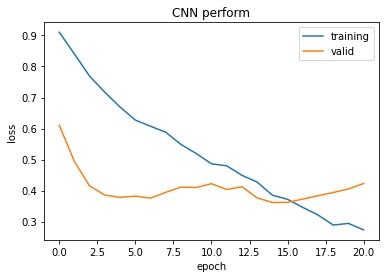

In [63]:
plt.plot(hist.history["loss"],label="training")
plt.plot (hist.history ["val_loss"],label="valid")
plt.title("CNN perform")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

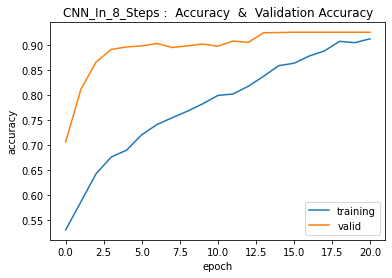

In [64]:
plt.plot(hist.history['accuracy'],label="training")
plt.plot(hist.history['val_accuracy'],label="valid")
plt.title('CNN_In_8_Steps :  Accuracy  &  Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.show()

Confusion Matrix
[[545 238]
 [ 14 768]]
Confusion Matrix_accurcy :
0.8389776357827476
classification_Report
              precision    recall  f1-score   support

        fake       0.97      0.70      0.81       783
        real       0.76      0.98      0.86       782

    accuracy                           0.84      1565
   macro avg       0.87      0.84      0.84      1565
weighted avg       0.87      0.84      0.84      1565



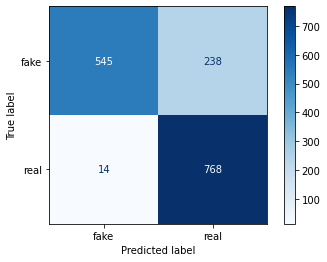

In [65]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report,accuracy_score
import numpy as np
target_names = ['fake', 'real']
label_names = [0,1]

Y_pred =model.predict(ds_test)
y_pred = np.argmax(Y_pred ,  axis = 1)

cm = confusion_matrix(ds_test.classes, y_pred, labels = label_names)


print('Confusion Matrix')
print(confusion_matrix(ds_test.classes, y_pred))
print('Confusion Matrix_accurcy :')

print(accuracy_score(ds_test.classes, y_pred))

print('classification_Report')
print(classification_report(ds_test.classes, y_pred, target_names=target_names))
#plot_confusion_matrix(ds_test,display_labels=target_names)

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
plt.show()
